# Note segmentation RNN training

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import GRU, Bidirectional, Dropout, Input, TimeDistributed, BatchNormalization, Dense, Conv1D, Activation
from keras.models import Model
from keras.optimizers import Adam
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


## Loading data

In [2]:
data = pd.read_pickle("../../Data/Guitar/File_onset_data_final.pkl")

In [3]:
np.mean(data["x"].apply(lambda x: x.shape[0]))

35000.0

In [4]:
data["Riff"] = data["File"].str.split("riff").str[-1].str.split(".").str[0].str.split("_").str[0]

In [5]:
train_riffs = np.random.choice(data["Riff"].unique(), size=int(0.8*data["Riff"].unique().shape[0]), replace=False)

In [6]:
train_riffs

array(['8', '11', '5', '15', '18', '21', '19', '13', '22', '3', '10',
       '16', '2', '20', '14', '17'], dtype=object)

In [7]:
train_data = data[data["Riff"].isin(train_riffs)].reset_index(drop=True)
val_data = data[~data["Riff"].isin(train_riffs)].reset_index(drop=True)
train_data.shape, val_data.shape

((113, 5), (38, 5))

Reshaping data

In [9]:
length = 35000

In [12]:
X_train = np.array([[[]]])
y_train = np.array([[[]]])
for i in range(train_data.shape[0]):
    x = train_data["x"].values[i].reshape((1, length, 1))
    X_train = np.append(X_train, x)
    y = train_data["y"].values[i].reshape((1, length//10, 1))
    y_train = np.append(y_train, y)
    
X_val = np.array([[[]]])
y_val = np.array([[[]]])
for i in range(val_data.shape[0]):
    x = val_data["x"].values[i].reshape((1, length, 1))
    X_val = np.append(X_val, x)
    y = val_data["y"].values[i].reshape((1, length//10, 1))
    y_val = np.append(y_val, y)

In [13]:
X_train = X_train.reshape(train_data.shape[0], length, 1)
X_val = X_val.reshape(val_data.shape[0], length, 1)
y_train = y_train.reshape(train_data.shape[0], length//10, 1)
y_val = y_val.reshape(val_data.shape[0], length//10, 1)

In [14]:
X_train.shape, y_train.shape

((113, 35000, 1), (113, 3500, 1))

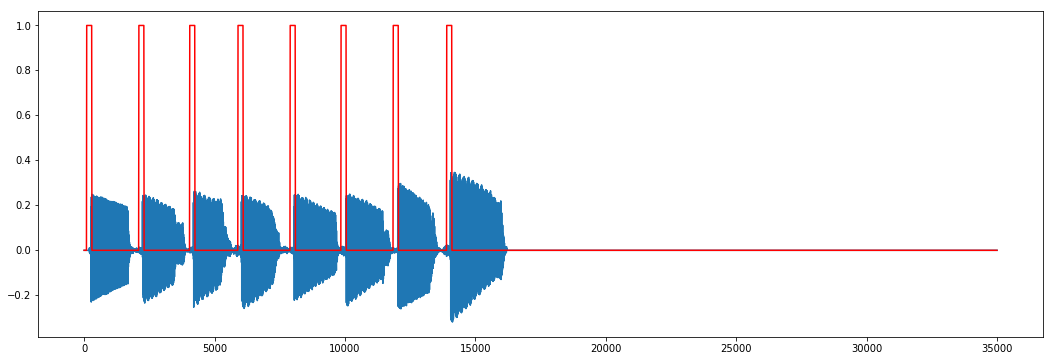

In [15]:
plt.figure(figsize=(18,6))
plt.plot(3*X_train[0])
plt.plot(np.arange(0, length, 10), y_train[0], "r")

## Model building

In [74]:
def build_model(input_shape):
    X_input = Input(shape=input_shape)
    X = Conv1D(196, kernel_size=10, strides=10)(X_input)
    X = BatchNormalization()(X)
    X = Activation("relu")(X)
    X = Bidirectional(GRU(units = 128, return_sequences = True))(X)
    X = BatchNormalization()(X)
    X_output = TimeDistributed(Dense(1, activation = "sigmoid"))(X)
    
    return Model(inputs=X_input, outputs=X_output)

In [75]:
model = build_model((length,1))

In [76]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 35000, 1)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 3500, 196)         2156      
_________________________________________________________________
batch_normalization_15 (Batc (None, 3500, 196)         784       
_________________________________________________________________
activation_8 (Activation)    (None, 3500, 196)         0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 3500, 256)         249600    
_________________________________________________________________
batch_normalization_16 (Batc (None, 3500, 256)         1024      
_________________________________________________________________
time_distributed_8 (TimeDist (None, 3500, 1)           257       
Total para

## Model training

In [77]:
model.compile(Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [78]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('Checkpoints/seg_gru_{val_acc:.2f}.hdf5', verbose=1, monitor='val_acc',
                             save_best_only=True, mode='auto')

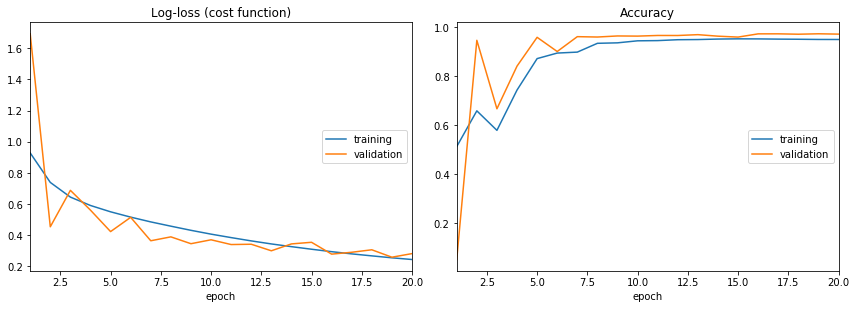

Log-loss (cost function):
training   (min:    0.244, max:    0.928, cur:    0.244)
validation (min:    0.259, max:    1.692, cur:    0.282)

Accuracy:
training   (min:    0.513, max:    0.952, cur:    0.949)
validation (min:    0.053, max:    0.972, cur:    0.971)

Epoch 00020: val_acc did not improve from 0.97237


In [79]:
model.fit(X_train, y_train, batch_size=32, epochs=20, 
          validation_data=(X_val, y_val), callbacks=[PlotLossesKeras(), checkpoint])

## Model evaluation

In [80]:
pred = model.predict(X_val)

In [81]:
pred.shape

(38, 3500, 1)

In [82]:
y_pred = (pred >= 0.5).astype(int)

In [83]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val.reshape(y_val.shape[0]*y_val.shape[1]), y_pred.reshape(y_pred.shape[0]*y_pred.shape[1]))

In [84]:
cm_norm = np.vstack((cm[0,:]/cm[0,:].sum(), cm[1,:]/cm[1,:].sum()))

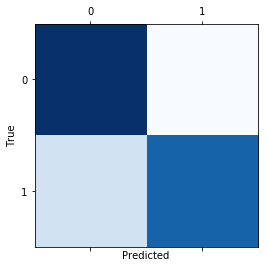

array([[0.981, 0.019],
       [0.209, 0.791]])

In [85]:
plt.matshow(cm_norm, cmap=plt.cm.Blues)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
cm_norm

In [86]:
from sklearn.metrics import classification_report
print(classification_report(y_val.reshape(y_val.shape[0]*y_val.shape[1]), y_pred.reshape(y_pred.shape[0]*y_pred.shape[1])))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98    126000
         1.0       0.70      0.79      0.74      7000

   micro avg       0.97      0.97      0.97    133000
   macro avg       0.84      0.89      0.86    133000
weighted avg       0.97      0.97      0.97    133000



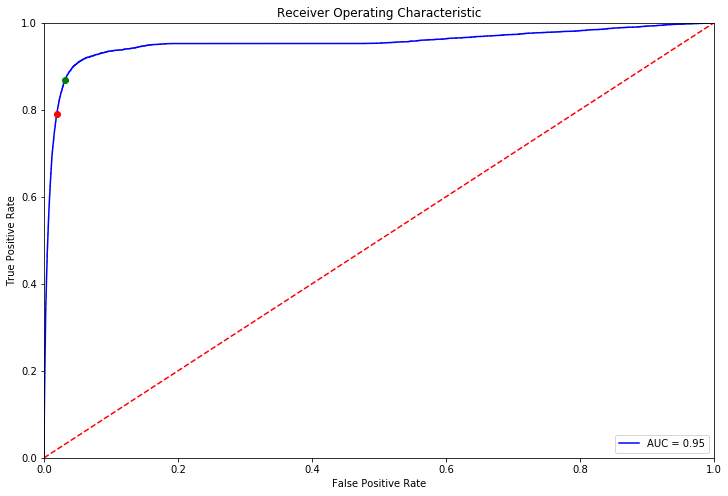

In [87]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_val.reshape(y_val.shape[0]*y_val.shape[1]), pred.reshape(pred.shape[0]*pred.shape[1]))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

thresh_0_5 = np.argmin(np.abs(threshold - 0.5))
plt.plot(fpr[thresh_0_5], tpr[thresh_0_5], "ro")
thresh_0_4 = np.argmin(np.abs(threshold - 0.4))
plt.plot(fpr[thresh_0_4], tpr[thresh_0_4], "go")
plt.show()

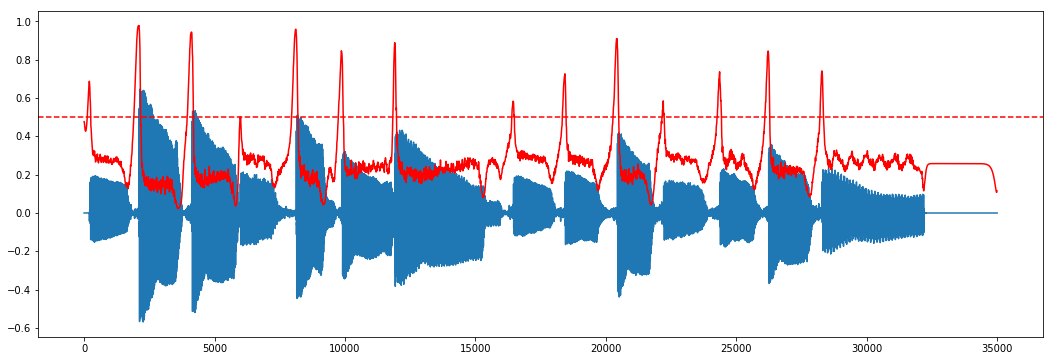

In [90]:
index = 20
plt.figure(figsize=(18,6))
plt.plot(3*X_val[index])
plt.plot(np.arange(0, length, 10), pred[index], "r")
plt.axhline(0.5, color="r", linestyle="--")